In [68]:
# sales_forecasting_example.ipynb

import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

In [69]:
# 1. Load raw sales data from ABC store
df = pd.read_csv("../data/Sales Prediction.csv")

# Standardize column names
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Drop rows where BOTH month and sales are NaN
df = df.dropna(subset=["month", "sales"], how="all").reset_index(drop=True)

# ---------- remove obvious outliers ----------
# 1) remove zero or negative sales
df = df[df["sales"] > 0].copy()

# 2) remove statistical outliers using IQR
q1 = df["sales"].quantile(0.25)
q3 = df["sales"].quantile(0.75)
iqr = q3 - q1

# this factor (1.5) usually catches "the weird spikes" like the ones in your plot
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df = df[(df["sales"] >= lower_bound) & (df["sales"] <= upper_bound)].copy()


# Overview of the raw data
print(df.head())
print(df.info())

   month      sales
0    1.0  24.321676
1    2.0  29.212176
2    3.0  33.632435
3    4.0  27.904117
4    5.0  31.633817
<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   month   97 non-null     float64
 1   sales   97 non-null     float64
dtypes: float64(2)
memory usage: 2.3 KB
None


In [72]:
# CASE 1: "month" is just a running number (1, 2, 3, ...) and we want to start at 2020-01
start_date = pd.Timestamp("2016-10-01")

# create a proper datetime column based on row position
# if your "month" column is 1-based and strictly increasing, we can do:
df["date"] = [start_date + pd.DateOffset(months=int(m - 1)) for m in df["month"]]

# # now we use "date" as the true time index
df = df.sort_values("date").reset_index(drop=True)

# # Overview of the raw data
print(df.head())
print(df.tail())

   month      sales       date
0    1.0  24.321676 2016-10-01
1    2.0  29.212176 2016-11-01
2    3.0  33.632435 2016-12-01
3    4.0  27.904117 2017-01-01
4    5.0  31.633817 2017-02-01
    month       sales       date
92   96.0  170.254691 2024-09-01
93   97.0  180.410457 2024-10-01
94   98.0  180.751846 2024-11-01
95   99.0  185.935582 2024-12-01
96  100.0  185.827322 2025-01-01


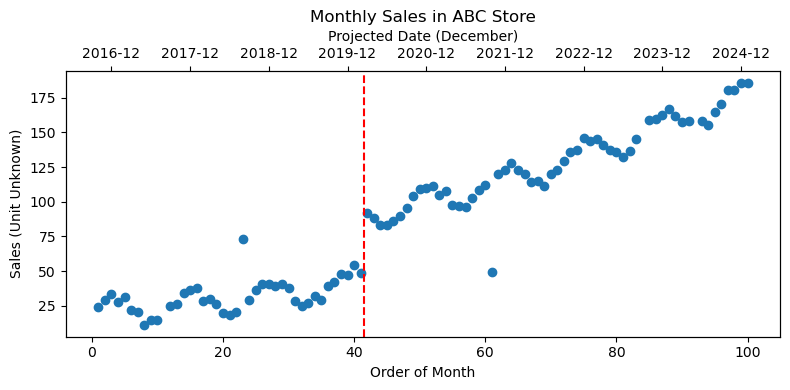

In [75]:
# Quick look at the data
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot sales using the bottom x-axis (month)
ax1.plot(df.month, df.sales, 'o')
ax1.set_xlabel('Order of Month')
ax1.set_ylabel('Sales (Unit Unknown)')
ax1.set_title('Monthly Sales in ABC Store')

# Create a secondary x-axis on top for date
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

# Show only December dates on the upper x-axis
december_mask = df.date.dt.month == 12
dec_months = df.month[december_mask]
dec_labels = df.date[december_mask].dt.strftime('%Y-%m')

ax2.set_xticks(dec_months)
ax2.set_xticklabels(dec_labels)
ax2.set_xlabel('Projected Date (December)')

# Add vertical reference line
ax1.axvline(x=41.5, color="red", linestyle="--", linewidth=1.5)

plt.tight_layout()
plt.show()

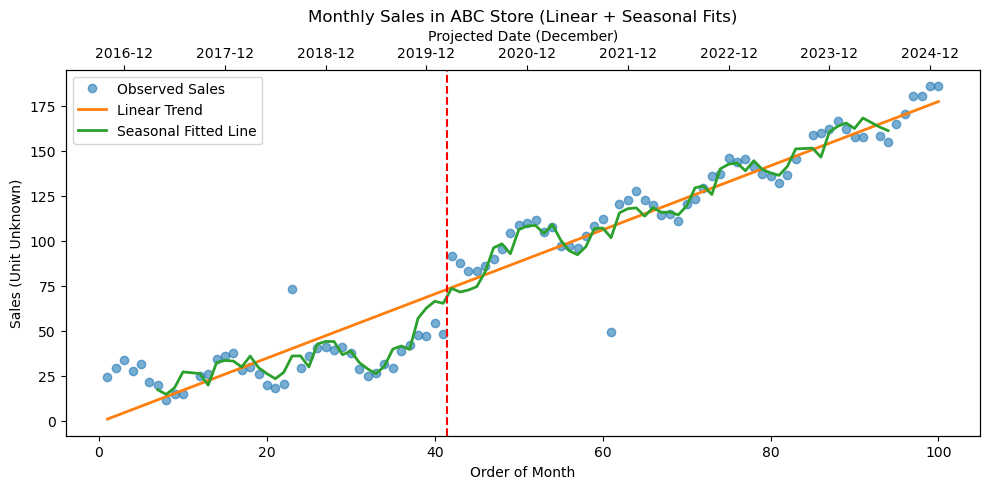

In [77]:
# 2. Linear regression fit
df2 = df.copy()   # ✅ make a copy before modifying

X = df2["month"].values.reshape(-1, 1)
y = df2["sales"].values
linreg = LinearRegression()
linreg.fit(X, y)
df2["trend_linear"] = linreg.predict(X)

# 3. Seasonal decomposition (using statsmodels)
df2 = df2.set_index("date")
result = seasonal_decompose(df2["sales"], model="additive", period=12)
df2["seasonal_fit"] = result.trend + result.seasonal

# 4. Plot data + linear fit + seasonal fit with two x-axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Bottom x-axis: month (numeric order)
ax1.plot(df2["month"], df2["sales"], "o", label="Observed Sales", alpha=0.6)
ax1.plot(df2["month"], df2["trend_linear"], "-", label="Linear Trend", linewidth=2)
ax1.plot(df2["month"], df2["seasonal_fit"], "-", label="Seasonal Fitted Line", linewidth=2)
ax1.axvline(x=41.5, color="red", linestyle="--", linewidth=1.5)

ax1.set_xlabel("Order of Month")
ax1.set_ylabel("Sales (Unit Unknown)")
ax1.set_title("Monthly Sales in ABC Store (Linear + Seasonal Fits)")

# Top x-axis: only December labels
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

december_mask = df2.index.month == 12
dec_months = df2["month"][december_mask]
dec_labels = df2.index[december_mask].strftime("%Y-%m")

ax2.set_xticks(dec_months)
ax2.set_xticklabels(dec_labels)
ax2.set_xlabel("Projected Date (December)")

ax1.legend(loc="upper left")
plt.tight_layout()
plt.show()

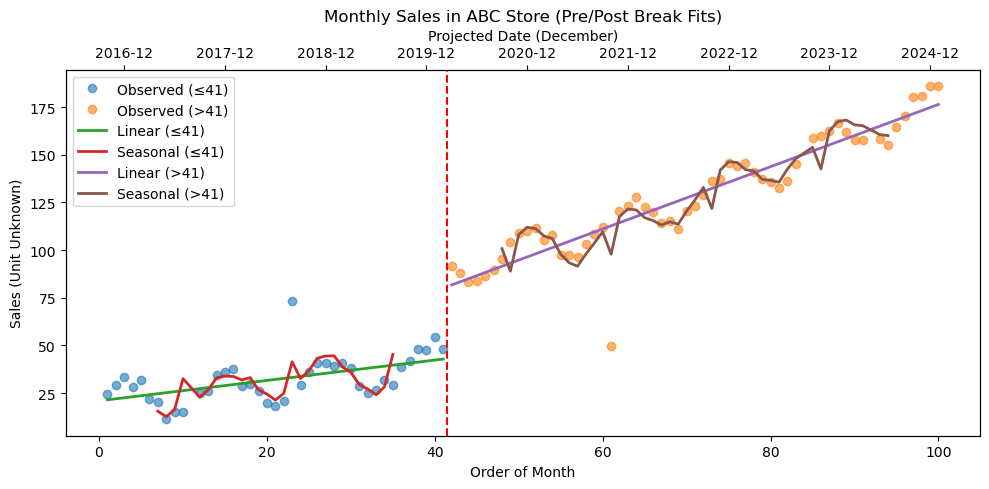

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose

# assume df already loaded, cleaned, and has: month, sales, date
# start from your copied version
df2 = df.copy()

# make sure date is indexable later
df2 = df2.sort_values("date").reset_index(drop=True)

# ---------- 1. split into two parts ----------
break_month = 41.5
df2_part1 = df2[df2["month"] <= 41].copy()
df2_part2 = df2[df2["month"] > 41].copy()

# ---------- 2. fit linear + seasonal for part 1 ----------
# linear
X1 = df2_part1["month"].values.reshape(-1, 1)
y1 = df2_part1["sales"].values
lin1 = LinearRegression()
lin1.fit(X1, y1)
df2_part1["trend_linear"] = lin1.predict(X1)

# seasonal: need datetime index
df2_part1_idx = df2_part1.set_index("date")
res1 = seasonal_decompose(df2_part1_idx["sales"], model="additive", period=12)
df2_part1["seasonal_fit"] = (res1.trend + res1.seasonal).values

# ---------- 3. fit linear + seasonal for part 2 ----------
# linear
X2 = df2_part2["month"].values.reshape(-1, 1)
y2 = df2_part2["sales"].values
lin2 = LinearRegression()
lin2.fit(X2, y2)
df2_part2["trend_linear"] = lin2.predict(X2)

# seasonal
df2_part2_idx = df2_part2.set_index("date")
res2 = seasonal_decompose(df2_part2_idx["sales"], model="additive", period=12)
df2_part2["seasonal_fit"] = (res2.trend + res2.seasonal).values

# ---------- 4. plot together with dual x-axes ----------
fig, ax1 = plt.subplots(figsize=(10, 5))

# scatter original points (both parts)
ax1.plot(df2_part1["month"], df2_part1["sales"], "o", label="Observed (≤41)", alpha=0.6)
ax1.plot(df2_part2["month"], df2_part2["sales"], "o", label="Observed (>41)", alpha=0.6)

# fitted lines for part 1
ax1.plot(df2_part1["month"], df2_part1["trend_linear"], "-", label="Linear (≤41)", linewidth=2)
ax1.plot(df2_part1["month"], df2_part1["seasonal_fit"], "-", label="Seasonal (≤41)", linewidth=2)

# fitted lines for part 2
ax1.plot(df2_part2["month"], df2_part2["trend_linear"], "-", label="Linear (>41)", linewidth=2)
ax1.plot(df2_part2["month"], df2_part2["seasonal_fit"], "-", label="Seasonal (>41)", linewidth=2)

# vertical line to show jump
ax1.axvline(x=41.5, color="red", linestyle="--", linewidth=1.5)

ax1.set_xlabel("Order of Month")
ax1.set_ylabel("Sales (Unit Unknown)")
ax1.set_title("Monthly Sales in ABC Store (Pre/Post Break Fits)")

# ---------- top x-axis with December only ----------
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

# Use the full df2 for December labels
december_mask = df2["date"].dt.month == 12
dec_months = df2["month"][december_mask]
dec_labels = df2["date"][december_mask].dt.strftime("%Y-%m")

ax2.set_xticks(dec_months)
ax2.set_xticklabels(dec_labels)
ax2.set_xlabel("Projected Date (December)")

ax1.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [79]:
# 3. Target
target_col = "sales"

# 4. Basic time features (use the unified 'date' column)
df["fea_year"] = df["date"].dt.year
df["fea_month"] = df["date"].dt.month
df["dayofweek"] = df["date"].dt.dayofweek  # for monthly data this will be similar, but ok to keep

# 5. Lag features
df["lag_1"] = df[target_col].shift(1)
df["lag_2"] = df[target_col].shift(2)
df["lag_7"] = df[target_col].shift(7)  # for monthly data this is a 7-month lag

# 6. Rolling features (use shifted target to avoid lookahead)
df["roll_3"] = df[target_col].shift(1).rolling(window=3).mean()
df["roll_6"] = df[target_col].shift(1).rolling(window=6).mean()

# Drop rows with NaN created by lagging/rolling
df = df.dropna().reset_index(drop=True)

# Quick look
print(df.head())
print(df.tail())

   month      sales       date  fea_year  fea_month  dayofweek      lag_1  \
0    8.0  11.334801 2017-05-01      2017          5          0  20.134899   
1    9.0  14.980235 2017-06-01      2017          6          3  11.334801   
2   10.0  14.990533 2017-07-01      2017          7          5  14.980235   
3   12.0  24.821180 2017-09-01      2017          9          4  14.990533   
4   13.0  26.051368 2017-10-01      2017         10          6  24.821180   

       lag_2      lag_7     roll_3     roll_6  
0  21.722341  24.321676  24.497019  27.373297  
1  20.134899  29.212176  17.730680  24.393735  
2  11.334801  33.632435  15.483312  21.285035  
3  14.980235  27.904117  13.768523  19.132771  
4  14.990533  31.633817  18.263982  17.997331  
    month       sales       date  fea_year  fea_month  dayofweek       lag_1  \
85   96.0  170.254691 2024-09-01      2024          9          6  164.711280   
86   97.0  180.410457 2024-10-01      2024         10          1  170.254691   
87   98.0

In [81]:
# assume df already has: date, month, target_col, and all feature cols built
# 1) keep only data AFTER the jump
df_after = df[df["month"] > 41].copy().reset_index(drop=True)

# if your target column was called "sales", set it here
target_col = "sales"   # adjust if your code used another name

# 2) train/test split only on post-jump data
# if you don't have 24 months after 41, fall back to 20%
test_size = 24 if len(df_after) > 24 else max(1, int(len(df_after) * 0.2))

train_df = df_after.iloc[:-test_size]
test_df = df_after.iloc[-test_size:]

feature_cols = [
    "fea_year",
    "fea_month",
    "dayofweek",
    "lag_1",
    "lag_2",
    "lag_7",
    "roll_3",
    "roll_6",
]

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

# 3) models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f"{name}: MAE={mae:.2f}, RMSE={rmse:.2f}")

# 3.1 Linear Regression (post-jump only)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)
evaluate_model("LinearRegression (post-jump)", y_test, y_pred_lr)

# 3.2 Simple Neural Network (optional)
nn = MLPRegressor(
    hidden_layer_sizes=(32, 16),
    random_state=42,
    max_iter=500
)
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)
evaluate_model("NeuralNetwork (post-jump)", y_test, y_pred_nn)

# 3.3 Optional: Logistic-style bins, still on post-jump
sales_bins = pd.qcut(train_df[target_col], q=3, labels=[0, 1, 2])
log_clf = LogisticRegression(max_iter=500)
log_clf.fit(X_train, sales_bins)
test_bins_pred = log_clf.predict(X_test)
print("LogisticRegression (classification) predicted bins:", np.unique(test_bins_pred))

# 4) Forecast NEXT 24 months, still from post-jump regime
date_col = "date"

last_date = df_after[date_col].max()
future_steps = 24  # months to forecast

future_rows = []
# very important: we extend ONLY the post-jump frame
current_df = df_after.copy()

for i in range(1, future_steps + 1):
    next_date = last_date + pd.DateOffset(months=i)

    row = {}
    row[date_col] = next_date
    row["fea_year"] = next_date.year
    row["fea_month"] = next_date.month
    row["dayofweek"] = next_date.dayofweek

    # lags from CURRENT post-jump history
    row["lag_1"] = current_df[target_col].iloc[-1]
    row["lag_2"] = current_df[target_col].iloc[-2] if len(current_df) >= 2 else current_df[target_col].iloc[-1]
    row["lag_7"] = current_df[target_col].iloc[-7] if len(current_df) >= 7 else current_df[target_col].iloc[0]

    row["roll_3"] = current_df[target_col].iloc[-3:].mean() if len(current_df) >= 3 else current_df[target_col].mean()
    row["roll_6"] = current_df[target_col].iloc[-6:].mean() if len(current_df) >= 6 else current_df[target_col].mean()

    row_df = pd.DataFrame([row])

    # predict with post-jump linear model
    y_fut = lin_reg.predict(row_df[feature_cols])[0]

    # append to current_df so that next lags can see it
    new_row_full = {
        date_col: next_date,
        target_col: y_fut,
        "fea_year": row["fea_year"],
        "fea_month": row["fea_month"],
        "dayofweek": row["dayofweek"],
        "lag_1": row["lag_1"],
        "lag_2": row["lag_2"],
        "lag_7": row["lag_7"],
        "roll_3": row["roll_3"],
        "roll_6": row["roll_6"],
    }
    current_df = pd.concat([current_df, pd.DataFrame([new_row_full])], ignore_index=True)
    future_rows.append({date_col: next_date, target_col: y_fut})

future_df = pd.DataFrame(future_rows)
print("Future prediction (next 24 months, post-jump regime only):")
print(future_df)

LinearRegression (post-jump): MAE=12.48, RMSE=14.56
NeuralNetwork (post-jump): MAE=11.94, RMSE=15.10
LogisticRegression (classification) predicted bins: [2]
Future prediction (next 24 months, post-jump regime only):
         date       sales
0  2025-02-01  161.778961
1  2025-03-01  160.399930
2  2025-04-01  166.144591
3  2025-05-01  168.554741
4  2025-06-01  166.554196
5  2025-07-01  171.316700
6  2025-08-01  169.073811
7  2025-09-01  176.258182
8  2025-10-01  175.614635
9  2025-11-01  173.724933
10 2025-12-01  179.101678
11 2026-01-01  179.225499
12 2026-02-01  177.402592
13 2026-03-01  178.105493
14 2026-04-01  183.351923
15 2026-05-01  183.314749
16 2026-06-01  188.911914
17 2026-07-01  187.495352
18 2026-08-01  185.576337
19 2026-09-01  190.490818
20 2026-10-01  190.488000
21 2026-11-01  188.632020
22 2026-12-01  194.495091
23 2027-01-01  193.930611


/Users/kevinchao/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


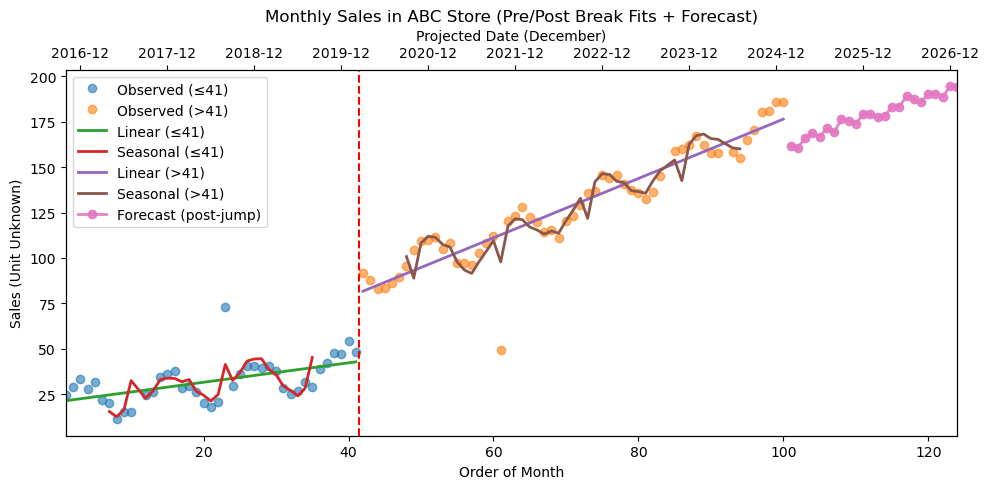

In [83]:
# ---------- 4. plot together with dual x-axes ----------
fig, ax1 = plt.subplots(figsize=(10, 5))

# scatter original points (both parts)
ax1.plot(df2_part1["month"], df2_part1["sales"], "o", label="Observed (≤41)", alpha=0.6)
ax1.plot(df2_part2["month"], df2_part2["sales"], "o", label="Observed (>41)", alpha=0.6)

# fitted lines for part 1
ax1.plot(df2_part1["month"], df2_part1["trend_linear"], "-", label="Linear (≤41)", linewidth=2)
ax1.plot(df2_part1["month"], df2_part1["seasonal_fit"], "-", label="Seasonal (≤41)", linewidth=2)

# fitted lines for part 2
ax1.plot(df2_part2["month"], df2_part2["trend_linear"], "-", label="Linear (>41)", linewidth=2)
ax1.plot(df2_part2["month"], df2_part2["seasonal_fit"], "-", label="Seasonal (>41)", linewidth=2)

# ---------- add predictive results (future_df) ----------
# future_df is from the post-jump model and has columns: date, sales
# we need to create the month index that continues from the last real month
last_month_num = df2_part2["month"].max()  # e.g. 60
future_df = future_df.copy()
future_df["month"] = np.arange(last_month_num + 1, last_month_num + 1 + len(future_df))

# plot predictions
ax1.plot(
    future_df["month"],
    future_df["sales"],
    "o-",
    label="Forecast (post-jump)",
    linewidth=2,
    alpha=0.9
)

# vertical line to show jump
ax1.axvline(x=41.5, color="red", linestyle="--", linewidth=1.5)

ax1.set_xlabel("Order of Month")
ax1.set_ylabel("Sales (Unit Unknown)")
ax1.set_title("Monthly Sales in ABC Store (Pre/Post Break Fits + Forecast)")

# ---------- top x-axis with December only ----------
ax2 = ax1.twiny()

# extend x-limits to include forecasts
all_min = min(df2_part1["month"].min(), df2_part2["month"].min())
all_max = max(future_df["month"].max(), df2_part2["month"].max())
ax1.set_xlim(all_min, all_max)
ax2.set_xlim(ax1.get_xlim())

# use December from df2, then append December from future_df
december_mask = df2["date"].dt.month == 12
dec_months = list(df2["month"][december_mask])
dec_labels = list(df2["date"][december_mask].dt.strftime("%Y-%m"))

# add future Decembers if any
future_dec = future_df[future_df["date"].dt.month == 12]
if not future_dec.empty:
    dec_months.extend(future_dec["month"].tolist())
    dec_labels.extend(future_dec["date"].dt.strftime("%Y-%m").tolist())

ax2.set_xticks(dec_months)
ax2.set_xticklabels(dec_labels)
ax2.set_xlabel("Projected Date (December)")

ax1.legend(loc="upper left")
plt.tight_layout()
plt.show()

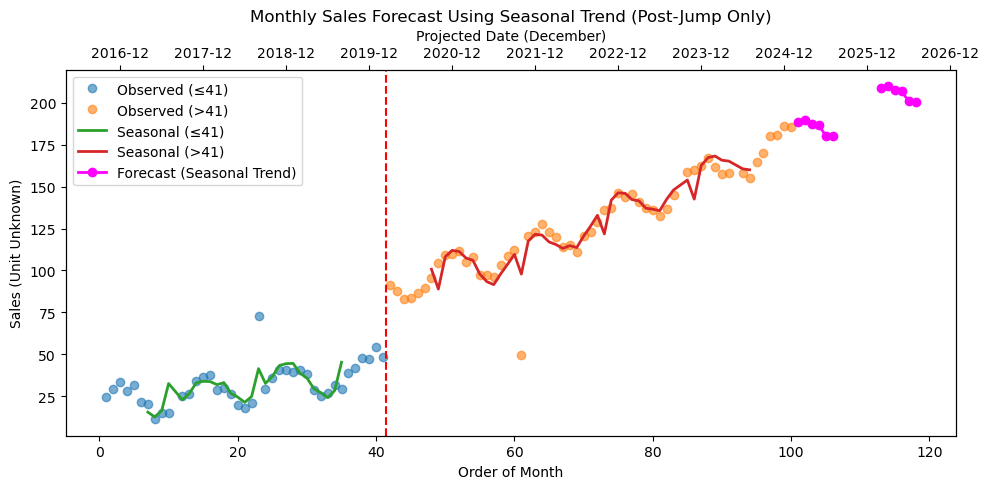

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# We'll base this on df2_part2 (post-jump)
df_post = df2_part2.copy()
period = 12  # monthly seasonality

# Extract the decomposed seasonal component and linear trend
trend_vals = df_post["trend_linear"].values
seasonal_vals = df_post["seasonal_fit"] - df_post["trend_linear"]

# 1. Forecast next N months
future_steps = 24
last_month = df_post["month"].max()
future_months = np.arange(last_month + 1, last_month + future_steps + 1)

# 2. Linear extrapolation of the trend
slope = (trend_vals[-1] - trend_vals[0]) / (len(trend_vals) - 1)
trend_forecast = trend_vals[-1] + slope * np.arange(1, future_steps + 1)

# 3. Repeat the last full seasonal cycle (wrap-around)
seasonal_cycle = seasonal_vals[-period:]
seasonal_forecast = np.tile(seasonal_cycle, int(np.ceil(future_steps / period)))[:future_steps]

# 4. Combine trend + seasonality
forecast_sales = trend_forecast + seasonal_forecast

# 5. Build DataFrame
future_df_seasonal = pd.DataFrame({
    "month": future_months,
    "sales": forecast_sales
})
future_df_seasonal["date"] = [
    df_post["date"].max() + pd.DateOffset(months=i)
    for i in range(1, future_steps + 1)
]

# ---------- Plot historical + seasonal forecast ----------
fig, ax1 = plt.subplots(figsize=(10, 5))

# historical
ax1.plot(df2_part1["month"], df2_part1["sales"], "o", label="Observed (≤41)", alpha=0.6)
ax1.plot(df2_part2["month"], df2_part2["sales"], "o", label="Observed (>41)", alpha=0.6)
ax1.plot(df2_part1["month"], df2_part1["seasonal_fit"], "-", label="Seasonal (≤41)", linewidth=2)
ax1.plot(df2_part2["month"], df2_part2["seasonal_fit"], "-", label="Seasonal (>41)", linewidth=2)

# forecast using seasonal trend
ax1.plot(
    future_df_seasonal["month"],
    future_df_seasonal["sales"],
    "o-",
    color="magenta",
    label="Forecast (Seasonal Trend)",
    linewidth=2,
)

# vertical split line
ax1.axvline(x=41.5, color="red", linestyle="--", linewidth=1.5)

ax1.set_xlabel("Order of Month")
ax1.set_ylabel("Sales (Unit Unknown)")
ax1.set_title("Monthly Sales Forecast Using Seasonal Trend (Post-Jump Only)")

# ---------- top x-axis (December labels) ----------
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

# existing Decembers from historical df2
december_mask = df2["date"].dt.month == 12
dec_months = list(df2["month"][december_mask])
dec_labels = list(df2["date"][december_mask].dt.strftime("%Y-%m"))

# Decembers from forecast
future_dec = future_df_seasonal[future_df_seasonal["date"].dt.month == 12]
if not future_dec.empty:
    dec_months.extend(future_dec["month"].tolist())
    dec_labels.extend(future_dec["date"].dt.strftime("%Y-%m").tolist())

ax2.set_xticks(dec_months)
ax2.set_xticklabels(dec_labels)
ax2.set_xlabel("Projected Date (December)")

ax1.legend(loc="upper left")
plt.tight_layout()
plt.show()
